In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
from glob import glob
import wandb
import re
from adjustText import adjust_text
import seaborn as sns
import scipy
import statannot
import argparse
import sys
sys.path.append('../../modified_medsam_repo')

In [2]:
def convert_to_df(base_path):

    dicto = {'label':[], 'lr':[], 'dice_sensitivity':[], 'dice_specificity':[], 'overall_dice':[]}
    for label in [1,5,18,58]:

        for lr in os.listdir(f'{base_path}/{label}'):
            path = f'{base_path}/{label}/{lr}/*.pkl'
            listo = glob(path)
            if len(listo) == 0:
                print(f'agh {path}' )
                continue
            path = listo[0]

            xx = pd.read_pickle(path)
            
            dicto['label'].append(label)
            dicto['lr'].append(float(lr))
            dicto['dice_sensitivity'].append(xx['dice_sensitivity'].item())
            dicto['dice_specificity'].append(xx['dice_specificity'].item())
            dicto['overall_dice'].append(xx['overall_dice'].item())

    df = pd.DataFrame(dicto)
    return df
df = convert_to_df('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_retune_lr_9-8-24/val')

In [15]:
df

,label,lr,dice_sensitivity,dice_specificity,overall_dice
0,1,0.00050,0.938266,0.997271,0.972505
1,1,0.00100,0.926936,0.991995,0.964687
2,1,0.00005,0.935087,0.989508,0.966666
3,1,0.00010,0.895452,0.996846,0.954288
4,5,0.00050,0.893976,0.995796,0.971538
5,5,0.00100,0.896980,0.995242,0.971831
6,5,0.00005,0.879416,0.992239,0.965359
7,5,0.00010,0.885621,0.994872,0.968843
8,18,0.00050,0.563362,0.996527,0.989057
9,18,0.00100,0.549377,0.997887,0.990153


Text(0.5, 0.98, 'Unet')

<Figure size 7680x5760 with 0 Axes>

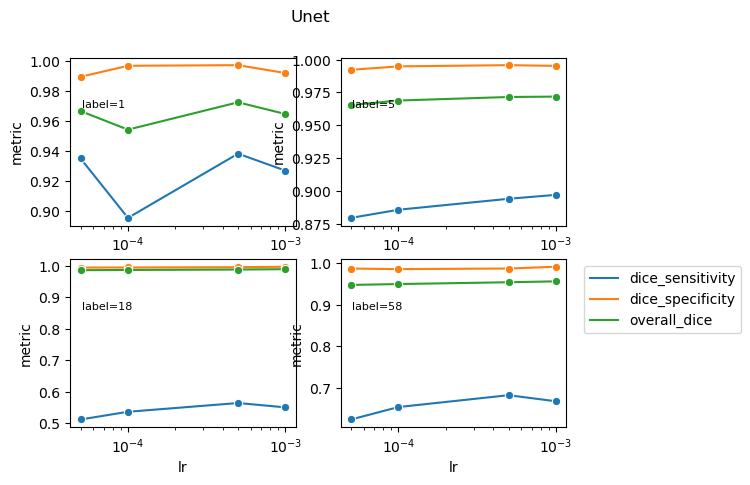

In [5]:
def plot_for_label(label_num, ax, dfo):
    subdf = dfo[dfo['label'] == label_num].reset_index(drop=True)
    dfmelt = pd.melt(subdf, id_vars=['label', 'lr'], value_vars = ['dice_sensitivity', 'dice_specificity', 'overall_dice'])
    sns.lineplot(dfmelt, x='lr', y='value', hue='variable', marker='o', ax=ax)
    ax.text(0.05, 0.75, f'label={label_num}', transform=ax.transAxes, fontsize=8, va='top', ha='left')
    ax.set(xscale='log')
    ax.set_ylabel('metric')
plt.figure(dpi=1200)
fig, axs = plt.subplots(2,2)
plot_for_label(1, axs[0,0], df)
plot_for_label(5, axs[0,1], df)
plot_for_label(18, axs[1,0], df)
plot_for_label(58, axs[1,1], df)

axs[0,0].get_legend().remove()
axs[0,1].get_legend().remove()
#axs[0,1].get_yaxis().set_visible(False)
axs[1,0].get_legend().remove()
axs[1,1].get_legend().remove()
#axs[1,1].get_yaxis().set_visible(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('Unet')

Text(0.5, 0.98, 'MedSAM')

<Figure size 7680x5760 with 0 Axes>

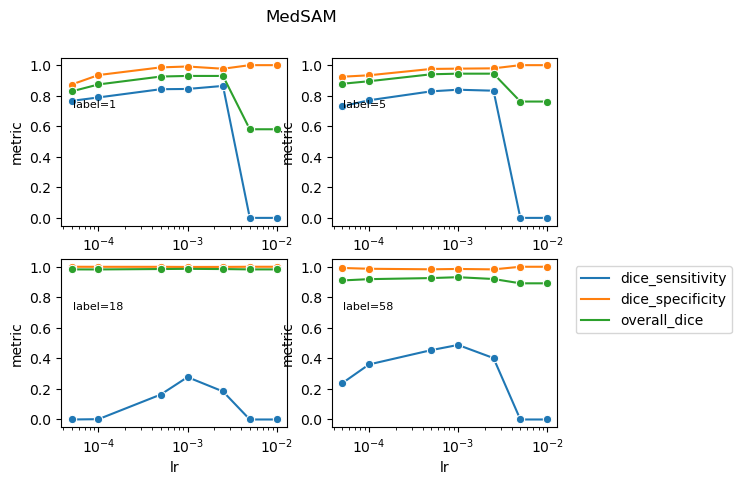

In [17]:
medsam_df = convert_to_df('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_retune_lr_9-8-24/val')
plt.figure(dpi=1200)
fig, axs = plt.subplots(2,2)
plot_for_label(1, axs[0,0], medsam_df)
plot_for_label(5, axs[0,1], medsam_df)
plot_for_label(18, axs[1,0], medsam_df)
plot_for_label(58, axs[1,1], medsam_df)

axs[0,0].get_legend().remove()
axs[0,1].get_legend().remove()
#axs[0,1].get_yaxis().set_visible(False)
axs[1,0].get_legend().remove()
axs[1,1].get_legend().remove()
#axs[1,1].get_yaxis().set_visible(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('MedSAM')

Text(0.5, 0.98, 'MedSAM DICE Loss')

<Figure size 7680x5760 with 0 Axes>

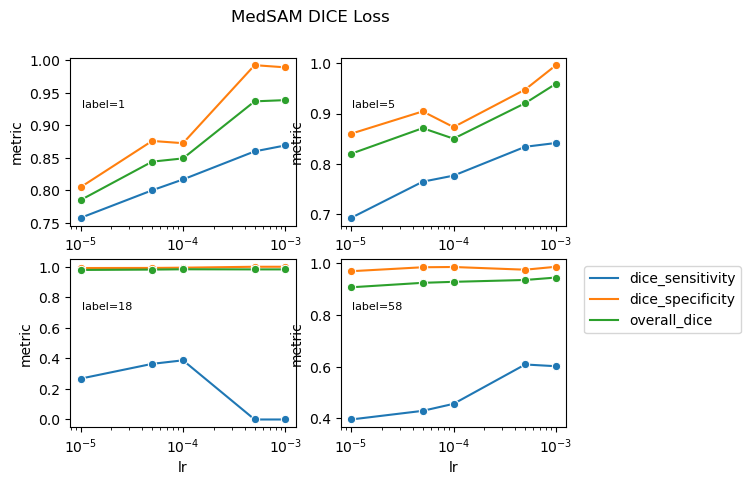

In [6]:
medsam_dice_df = convert_to_df('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_dice_retune_lr_11-3-24/val')
plt.figure(dpi=1200)
fig, axs = plt.subplots(2,2)
plot_for_label(1, axs[0,0], medsam_dice_df)
plot_for_label(5, axs[0,1], medsam_dice_df)
plot_for_label(18, axs[1,0], medsam_dice_df)
plot_for_label(58, axs[1,1], medsam_dice_df)

axs[0,0].get_legend().remove()
axs[0,1].get_legend().remove()
#axs[0,1].get_yaxis().set_visible(False)
axs[1,0].get_legend().remove()
axs[1,1].get_legend().remove()
#axs[1,1].get_yaxis().set_visible(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('MedSAM DICE Loss')